In [1]:
import numpy as np
import re
import ast
import os
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import cell_order_log_analysis

In [2]:
FONTSIZE = 16
LINESTYLE = (0,(4,4))
LINEWIDTH = 2.5
SAVE_FIG = True

RESERVATION = 'RES129958'
reservation_data_dir = '../data/' + RESERVATION + '/'
cell_order_ue_log_filenames = os.listdir(reservation_data_dir)
cell_order_log_filename = reservation_data_dir + 'cell-order.log'
cell_order_ue_log_filenames.remove('cell-order.log')

if (SAVE_FIG):
    reservation_out_dir = '../outputs/' + RESERVATION + '/'
    if (not os.path.exists(reservation_out_dir)):
        os.mkdir(reservation_out_dir)

SLA_PERIOD = 30 # seconds over which the SLAs are negotiated
OUTLIER_PERCENTILE = 5 # Percentile to clip-off from both ends for each SLA period

slice_delay_budget_msec = {0: [60, 90], 1: [30, 50], 2: [5, 15]}

Cell-Order log line:

`2022-10-11 22:06:02,322 INFO     ts_ms:1665525962322 slice_metrics:{0: {'cur_slice_mask': '11111111111000000', 'new_num_rbgs': 5, 'tx_brate downlink [Mbps]': 0.581407, 'dl_mcs': 15.109150000000001, 'num_slice_users': 1, 'dl_latency [msec]': 42767.857142857145, 'dl_buffer [bytes]': 1197.5}, 1: {'cur_slice_mask': '00000000000111000', 'new_num_rbgs': 1, 'tx_brate downlink [Mbps]': 1.8524399999999996, 'dl_mcs': 17.860975, 'num_slice_users': 1, 'dl_latency [msec]': 31.07824910950225, 'dl_buffer [bytes]': 6194.0}, 2: {'cur_slice_mask': '00000000000000110', 'new_num_rbgs': 4, 'tx_brate downlink [Mbps]': 1.6356709999999999, 'dl_mcs': 14.964575, 'num_slice_users': 1, 'dl_latency [msec]': 52.21106831625903, 'dl_buffer [bytes]': 7935.5}}`


In [3]:
bs_data, slice_delay_budget_msec, ts_start = cell_order_log_analysis.read_cell_order_log(cell_order_log_filename)
cell_order_log_analysis.summarize_over_sla_period(bs_data, SLA_PERIOD, OUTLIER_PERCENTILE)

ue_data = {}
for cell_order_ue_log_filename in cell_order_ue_log_filenames:
    cur_filename = reservation_data_dir + cell_order_ue_log_filename
    cur_data, slice_id, _ = cell_order_log_analysis.read_cell_order_ue_log(cur_filename, ts_start)
    assert slice_id not in ue_data.keys(), 'Multiple UEs under the same slice!'
    ue_data[slice_id] = cur_data
cell_order_log_analysis.summarize_over_sla_period(ue_data, SLA_PERIOD, OUTLIER_PERCENTILE)

Data for 1277.263000011444 seconds has been extracted
UE Data for 1307.3020000457764 seconds has been extracted
UE Data for 1302.792000055313 seconds has been extracted


Latency budget for slice 0: [60, 90] msec
Latency budget for slice 1: [30, 50] msec
Latency budget for slice 2: [0, 15] msec


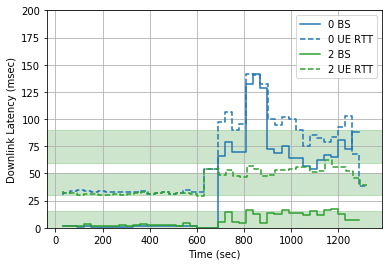

In [4]:
plt.figure()

for s_idx, metrics in bs_data.items():
    plt.step(metrics['ts_sec'], metrics['lat_msec'], 
             label=str(s_idx) + ' BS', where='pre', color='C'+str(s_idx))
    plt.step(ue_data[s_idx]['ts_sec'], ue_data[s_idx]['rtt_msec'], 
             label=str(s_idx) + ' UE RTT', where='pre', color='C'+str(s_idx), 
             linestyle='--')

for s_idx, budget in slice_delay_budget_msec.items():
    print("Latency budget for slice {}: {} msec".format(s_idx, budget))
    plt.gca().axhspan(budget[0], budget[1], alpha=0.2, color='green')

# plt.yscale('log')
plt.ylim([0,200])

plt.xlabel('Time (sec)')
plt.ylabel('Downlink Latency (msec)')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'lat.png')

plt.show()


In [5]:

STAT_ANALYSIS_START_TIME = 700
STAT_ANALYSIS_END_TIME = 3000
cell_order_log_analysis.print_latency_stats(bs_data, 
                                            STAT_ANALYSIS_START_TIME, 
                                            STAT_ANALYSIS_END_TIME, 
                                            slice_delay_budget_msec)


	Latency values for slice 0: ([60,90]: 75.00%) ([55,95]: 80.00%) ([50,100]: 85.00%) (Low-Lat Rate: 85.00%)

[ 65.95118058  78.97834816  69.66064222  70.11009055 131.90557183
 141.06365374 128.62370003  72.38253667  68.72920005  75.11393825
  64.11849438  64.64019262  56.98756494  54.11759934  62.3197371
  67.26779388  65.47192494  80.78263897  72.30048691  87.90317748]

	Latency values for slice 2: ([0,15]: 75.00%) ([0,20]: 100.00%) ([0,25]: 100.00%) (Low-Lat Rate: 75.00%)

[ 5.27553148 14.23480263  5.63889861  4.21551161 16.26612097 12.30178901
  4.85753394 13.66120679 12.29850271 16.10484939 13.5704039  13.53377801
 11.61680887 15.49031649 11.49315059 16.16263298 17.70715511 12.99710877
  7.37523094  6.81715381]


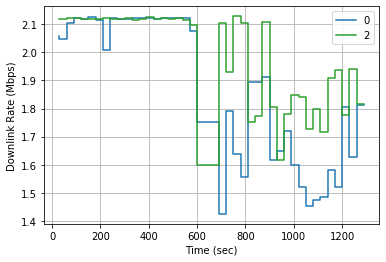

In [6]:
plt.figure()

for s_idx, metrics in bs_data.items():
    plt.step(metrics['ts_sec'], metrics['tx_mbps'], 
             label=s_idx, where='pre', color='C'+str(s_idx))

plt.xlabel('Time (sec)')
plt.ylabel('Downlink Rate (Mbps)')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'rate.png')

plt.show()

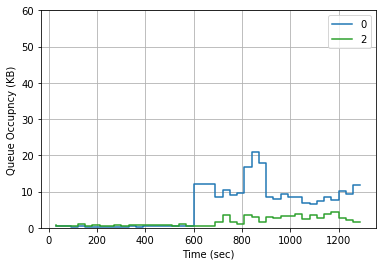

In [7]:
plt.figure()

for s_idx, metrics in bs_data.items():
    plt.step(metrics['ts_sec'], metrics['buf_bytes'] / 1e3, 
             label=s_idx, where='pre', color='C'+str(s_idx))

plt.ylim([0,60])

plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupncy (KB)')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'buf.png')

plt.show()

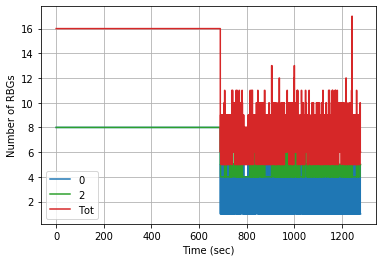

In [8]:
plt.figure()

for s_idx, metrics in bs_data.items():
    plt.step(metrics['raw_ts_sec'], metrics['raw_n_rbgs'], 
             label=s_idx, where='pre', color='C'+str(s_idx))

cum_n_rbgs = np.zeros_like(bs_data[list(bs_data)[0]]['raw_n_rbgs'])
ts_cum_n_rbgs = bs_data[list(bs_data)[0]]['raw_ts_sec']
max_s_idx = 0
for s_idx, metrics in bs_data.items():
    cur_n_rbgs = metrics['raw_n_rbgs']
    len_diff = len(cur_n_rbgs) - len(cum_n_rbgs)
    if (len_diff > 0):
        cum_n_rbgs = np.append(np.zeros(len_diff).astype(int), cum_n_rbgs)
        ts_cum_n_rbgs = metrics['raw_ts_sec']
    elif (len_diff < 0):
        cur_n_rbgs = np.append(np.zeros(-1*len_diff).astype(int), cur_n_rbgs)
    cum_n_rbgs += cur_n_rbgs
    max_s_idx = max(max_s_idx, s_idx)
plt.step(ts_cum_n_rbgs, cum_n_rbgs, label='Tot', 
         where='pre', color='C'+str(max_s_idx+1))

plt.xlabel('Time (sec)')
plt.ylabel('Number of RBGs')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'rbgs.png')

plt.show()

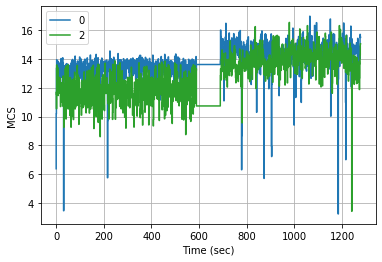

In [9]:
if ('raw_mcs' in bs_data[list(bs_data)[0]].keys()):
    plt.figure()

    for s_idx, metrics in bs_data.items():
        plt.step(metrics['raw_ts_sec'], metrics['raw_mcs'], 
                label=s_idx, where='pre', color='C'+str(s_idx))

    plt.xlabel('Time (sec)')
    plt.ylabel('MCS')
    plt.legend()
    plt.grid()

    if SAVE_FIG:
        plt.savefig(reservation_out_dir + 'mcs.png')

    plt.show()

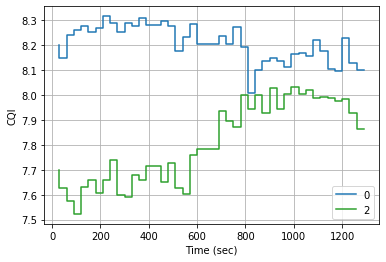

In [10]:
if ('cqi' in bs_data[list(bs_data)[0]].keys()):
    plt.figure()

    for s_idx, metrics in bs_data.items():
        plt.step(metrics['ts_sec'], metrics['cqi'], 
                label=s_idx, where='pre', color='C'+str(s_idx))

    plt.xlabel('Time (sec)')
    plt.ylabel('CQI')
    plt.legend()
    plt.grid()

    if SAVE_FIG:
        plt.savefig(reservation_out_dir + 'cqi.png')

    plt.show()

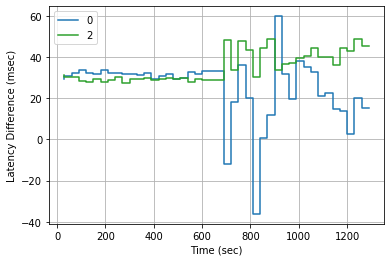

In [11]:
plt.figure()

for s_idx, metrics in bs_data.items():
    bs_data_len = len(metrics['lat_msec'])
    ue_data_len = len(ue_data[s_idx]['rtt_msec'])
    min_data_len = min(bs_data_len,ue_data_len)
    plt.step(metrics['ts_sec'], 
            ue_data[s_idx]['rtt_msec'][:min_data_len] - metrics['lat_msec'][:min_data_len], 
             label=str(s_idx), where='pre', color='C'+str(s_idx))

plt.xlabel('Time (sec)')
plt.ylabel('Latency Difference (msec)')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'lat_match.png')
    
plt.show()